In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import gc 

# 分布確認
import ydata_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")


# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
import japanize_matplotlib

## データ確認

In [2]:
# 学習データ
df_train = pd.read_csv("../data/input/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# テストデータ
df_test = pd.read_csv("../data/input/test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
print(df_train.shape)
print("レコード数:", len(df_train))
print("カラム数:", len(df_train.columns))

print(df_test.shape)
print("レコード数:", len(df_test))
print("カラム数:", len(df_test.columns))

(891, 12)
レコード数: 891
カラム数: 12
(418, 11)
レコード数: 418
カラム数: 11


下記のデータが変数となっている。 Survivedが目的変数。

PassengerId – 乗客識別ユニークID
Survived – 生存フラグ（0=死亡、1=生存）
Pclass – チケットクラス (1=1等, 2, 3)
Name – 乗客の名前
Sex – 性別（male=男性、female＝女性）
Age – 年齢
SibSp – タイタニックに同乗している兄弟/配偶者の数。兄弟（Siblings）や配偶者（Spouses）
parch – タイタニックに同乗している親/子供の数
ticket – チケット番号
fare – 料金
cabin – 客室番号
Embarked – 出港地（タイタニックへ乗った港）C=シェルブール、Q=クイーンズタウン、S=サウサンプトン)

### データ型の確認

In [5]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

### 統計量の確認

In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [8]:
print("df_train.isnull")
print(df_train.isnull().sum())

print("\ndf_test.isnull")
print(df_test.isnull().sum())

df_train.isnull
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

df_test.isnull
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# データセットの検討
データをみてどの説明変数を使うかを検討する

### 特徴量の確認
生存情報と各パラメータの関連を見たい

In [9]:
import seaborn as sns # Samuel Norman Seabornからとっている

男女で死亡率は変わる。

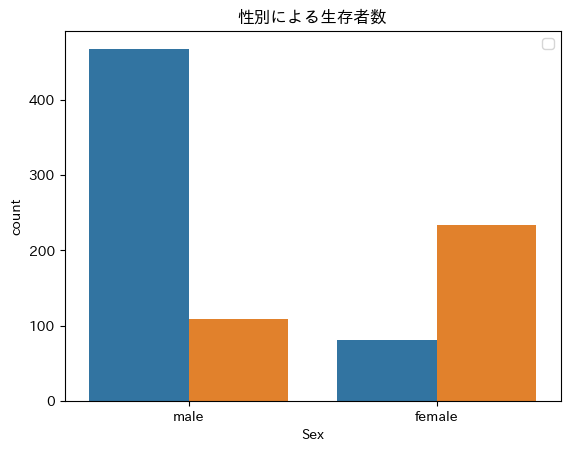

In [10]:
sns.countplot(x = 'Sex', hue="Survived", data=df_train)
plt.title("性別による生存者数")
plt.legend("死亡", "生存")
plt.show()

クロス分析による分析。

In [11]:
display(pd.crosstab(df_train["Sex"], df_train["Survived"], normalize="index"))

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


##  分析の関数化
この方法はよさそうなので各変数に対して行ってみる

In [12]:
def check_croostab(x, hue, data):
    sns.countplot(x = x, hue=hue, data=data)
    plt.title(x + "による生存者数")
    plt.show()
    display(pd.crosstab(df_train[x], df_train["Survived"], normalize="index"))

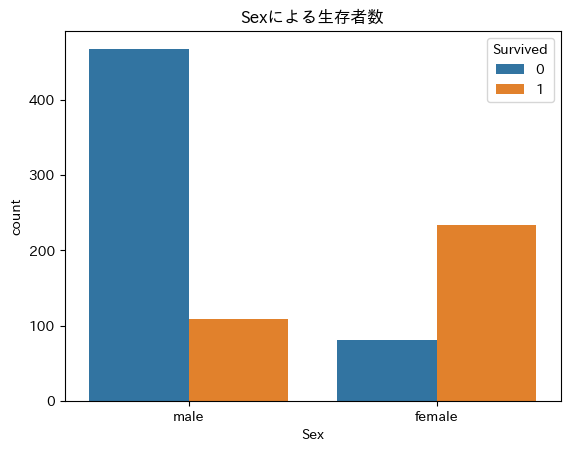

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [13]:
check_croostab("Sex", "Survived", df_train)

## Pclass
3等級は生存率が低い

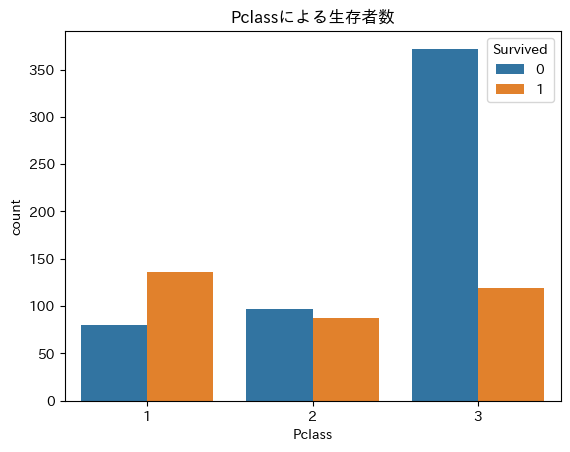

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


In [14]:
check_croostab("Pclass", "Survived", df_train)

### 年齢
ヒストグラムを解析する


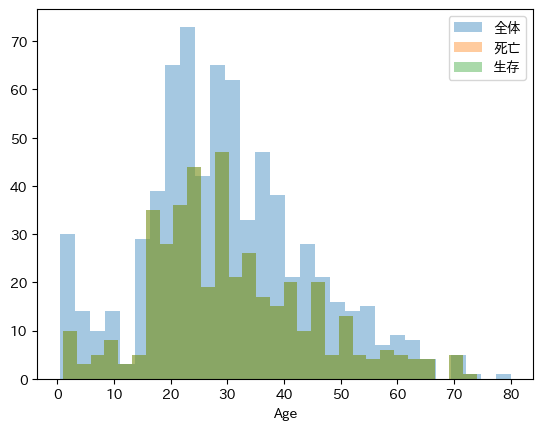

In [15]:
sns.distplot(df_train["Age"].dropna(), kde=False, bins=30, label="全体")
sns.distplot(df_train[df_train["Survived"] == 0].Age.dropna(), kde=False, bins=30, label="死亡")
sns.distplot(df_train[df_train["Survived"] == 0].Age.dropna(), kde=False, bins=30, label="生存")
plt.legend()

初めのBINで生存率高い

In [16]:
df_train["CutAge"] = pd.cut(df_train["Age"], 8) # 年齢を8等分した変数を作成
display(pd.crosstab(df_train["CutAge"], df_train["Survived"], normalize="index"))

Survived,0,1
CutAge,,
"(0.34, 10.368]",0.406250,0.593750
"(10.368, 20.315]",0.617391,0.382609
"(20.315, 30.263]",0.634783,0.365217
"(30.263, 40.21]",0.554839,0.445161
"(40.21, 50.158]",0.616279,0.383721
"(50.158, 60.105]",0.595238,0.404762
"(60.105, 70.052]",0.764706,0.235294
"(70.052, 80.0]",0.800000,0.200000


### 運賃

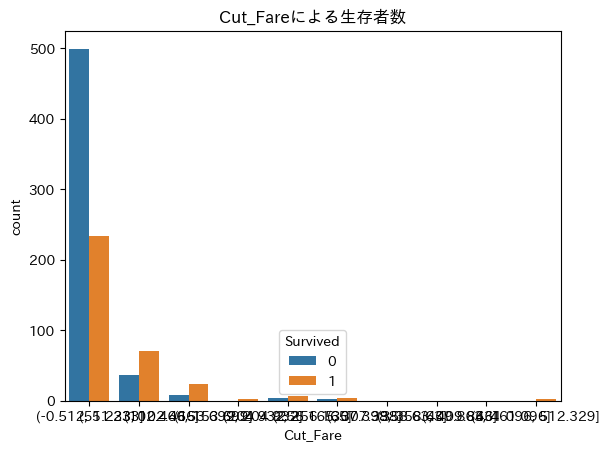

Survived,0,1
Cut_Fare,,
"(-0.512, 51.233]",0.681694,0.318306
"(51.233, 102.466]",0.339623,0.660377
"(102.466, 153.699]",0.258065,0.741935
"(153.699, 204.932]",0.000000,1.000000
"(204.932, 256.165]",0.363636,0.636364
"(256.165, 307.398]",0.333333,0.666667
"(461.096, 512.329]",0.000000,1.000000


In [17]:
df_train["Cut_Fare"] = pd.cut(df_train["Fare"], 10) # 年齢を10等分した変数を作成
check_croostab("Cut_Fare", "Survived", df_train)

# データセットの作成

* 性別は数値でないためOneHotVectorで数値化する

In [18]:
df_one = pd.get_dummies(df_train[["Sex"]], dummy_na=False, drop_first=False)
df_one = df_one.astype(np.int64)

df_sex_test = pd.get_dummies(df_test[["Sex"]], dummy_na=False, drop_first=False)

df_one.head()

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [19]:
x_train = pd.concat([df_one, df_train[["Pclass", "Fare"]]], axis=1)
y_train = df_train[["Survived"]]
id_train = df_train[["PassengerId"]]

x_test = pd.concat([df_sex_test, df_test[["Pclass", "Fare"]]], axis=1)

x_train.head()

,Sex_female,Sex_male,Pclass,Fare
0,0,1,3,7.2500
1,1,0,1,71.2833
2,1,0,3,7.9250
3,1,0,1,53.1000
4,0,1,3,8.0500


# 検証の方針

## 検証データ
* 交差検証を用いる
  * 5分割する。cv (Cross Validation)
  * StratifiedKFold.split()の結果は学習用データと検証用データのインデックス

In [20]:
n_splits = 5
list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

[(array([  0,   1,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,  15,
          16,  18,  19,  20,  21,  22,  23,  24,  25,  27,  28,  30,  31,
          32,  33,  35,  36,  37,  39,  40,  41,  42,  43,  44,  46,  47,
          49,  50,  51,  52,  53,  54,  58,  59,  60,  63,  64,  65,  66,
          67,  68,  69,  71,  73,  74,  75,  76,  77,  78,  81,  82,  84,
          85,  86,  87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,
          99, 100, 101, 102, 103, 104, 106, 107, 109, 110, 111, 113, 114,
         115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130,
         131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144,
         147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161,
         162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
         176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190,
         191, 192, 193, 194, 196, 198, 199, 200, 201, 202, 203, 205, 206,
         207, 208, 209, 210, 211, 212,


## モデル
* LightGBMを用いる

# ベースラインの作成

## ハイパーパラメータの探索

In [21]:
# 探索しないハイパーパラメータ
params_base = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.02,
    'n_estimators': 100000,
    "bagging_freq": 1,
    "seed": 123,
}

In [22]:
import optuna

In [23]:
# 目的関数
def objective(trial):
    # 探索するハイパーパラメータ
    params_tuning = {
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e2, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(x_train, y_train))
    for nfold in np.arange(5):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
        model = lgb.LGBMClassifier(**params_tuning)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr), (x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=0,
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5, 1, 0))
        list_metrics.append(metric_va)
    
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

#### 最適化処理（探索の実行）

In [24]:
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=30)

[I 2023-10-29 21:03:10,488] A new study created in memory with name: no-name-d0817e16-e67a-43dd-b838-966a1974cb55


[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l1 is set=0.492522233779106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.492522233779106
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.792414358623587e-05
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] lambda_l2 is set=83.76388146302445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.76388146302445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_f

[I 2023-10-29 21:03:10,909] Trial 0 finished with value: 0.7541711129244868 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'lambda_l1': 0.492522233779106, 'lambda_l2': 83.76388146302445}. Best is trial 0 with value: 0.7541711129244868.


[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] lambda_l1 is set=0.567922374174008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567922374174008
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015009027543233888
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] lambda_l2 is set=0.01732652966363563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01732652966363563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:11,291] Trial 1 finished with value: 0.7588600841127363 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 0.00015009027543233888, 'feature_fraction': 0.6715890080754348, 'bagging_fraction': 0.8645248536920208, 'lambda_l1': 0.567922374174008, 'lambda_l2': 0.01732652966363563}. Best is trial 1 with value: 0.7588600841127363.


[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] lambda_l1 is set=0.567922374174008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567922374174008
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015009027543233888
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] lambda_l2 is set=0.01732652966363563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01732652966363563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:11,571] Trial 2 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 3.52756635172055e-05, 'feature_fraction': 0.5877258780737462, 'bagging_fraction': 0.7657756869209191, 'lambda_l1': 1.3406343673102123, 'lambda_l2': 3.4482904089131434}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=1.3406343673102123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3406343673102123
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] lambda_l2 is set=3.4482904089131434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4482904089131434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2023-10-29 21:03:11,866] Trial 3 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 146, 'min_sum_hessian_in_leaf': 0.0006808799287054756, 'feature_fraction': 0.8612216912851107, 'bagging_fraction': 0.6614794569265892, 'lambda_l1': 0.2799978022399009, 'lambda_l2': 0.08185645330667264}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] lambda_l1 is set=0.9434967110751797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9434967110751797
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.889360449174926e-05
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] lambda_l2 is set=0.5050346330980694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5050346330980694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:12,134] Trial 4 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 128, 'min_sum_hessian_in_leaf': 1.889360449174926e-05, 'feature_fraction': 0.7168505863397641, 'bagging_fraction': 0.7154313816648219, 'lambda_l1': 0.9434967110751797, 'lambda_l2': 0.5050346330980694}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] lambda_l1 is set=0.9434967110751797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9434967110751797
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.889360449174926e-05
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] lambda_l2 is set=0.5050346330980694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5050346330980694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:12,466] Trial 5 finished with value: 0.7519239219132509 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 88, 'min_sum_hessian_in_leaf': 0.004788147156768277, 'feature_fraction': 0.9720800091019398, 'bagging_fraction': 0.7509183379421682, 'lambda_l1': 3.1319282717196035, 'lambda_l2': 0.029005047452739414}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.9720800091019398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720800091019398
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] lambda_l1 is set=3.1319282717196035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1319282717196035
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004788147156768277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.004788147156768277
[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509183379421682
[LightGBM] [Warning] lambda_l2 is set=0.029005047452739414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029005047452739414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:12,619] Trial 6 finished with value: 0.6161634548992531 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 0.003971252247766701, 'feature_fraction': 0.6252276826982534, 'bagging_fraction': 0.7415171321313522, 'lambda_l1': 87.54657140659076, 'lambda_l2': 1.1965765212602313}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.6252276826982534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252276826982534
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] lambda_l1 is set=87.54657140659076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=87.54657140659076
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003971252247766701, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.003971252247766701
[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415171321313522
[LightGBM] [Warning] lambda_l2 is set=1.1965765212602313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1965765212602313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_f

[I 2023-10-29 21:03:13,335] Trial 7 finished with value: 0.7642834724750486 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0030131614432849746, 'feature_fraction': 0.8015300642054637, 'bagging_fraction': 0.7725340032332324, 'lambda_l1': 0.23499322154972468, 'lambda_l2': 0.1646202117975735}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.7552111687390055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552111687390055
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] lambda_l1 is set=2.206714812711709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.206714812711709
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00423029374725911, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00423029374725911
[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346568914811361
[LightGBM] [Warning] lambda_l2 is set=3.1594683442464033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1594683442464033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_f

[I 2023-10-29 21:03:13,604] Trial 8 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 138, 'min_sum_hessian_in_leaf': 0.00423029374725911, 'feature_fraction': 0.7552111687390055, 'bagging_fraction': 0.8346568914811361, 'lambda_l1': 2.206714812711709, 'lambda_l2': 3.1594683442464033}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] lambda_l1 is set=0.05982625838323253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05982625838323253
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.776580803025408e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.776580803025408e-05
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] lambda_l2 is set=1.9490717640641542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9490717640641542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] f

[I 2023-10-29 21:03:13,972] Trial 9 finished with value: 0.7822610005649364 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 170, 'min_sum_hessian_in_leaf': 1.776580803025408e-05, 'feature_fraction': 0.8818414207216692, 'bagging_fraction': 0.6218331872684371, 'lambda_l1': 0.05982625838323253, 'lambda_l2': 1.9490717640641542}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] lambda_l1 is set=0.05982625838323253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05982625838323253
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.776580803025408e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.776580803025408e-05
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] lambda_l2 is set=1.9490717640641542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9490717640641542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] f

[I 2023-10-29 21:03:14,206] Trial 10 finished with value: 0.716163454899253 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 200, 'min_sum_hessian_in_leaf': 8.920338990414188e-05, 'feature_fraction': 0.5040305717020104, 'bagging_fraction': 0.9940542446575642, 'lambda_l1': 0.010612397212799442, 'lambda_l2': 18.289897792948295}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.5040305717020104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040305717020104
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l1 is set=0.010612397212799442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010612397212799442
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.920338990414188e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.920338990414188e-05
[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940542446575642
[LightGBM] [Warning] lambda_l2 is set=18.289897792948295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.289897792948295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning]

[I 2023-10-29 21:03:14,472] Trial 11 finished with value: 0.6386353650116126 and parameters: {'num_leaves': 243, 'min_data_in_leaf': 150, 'min_sum_hessian_in_leaf': 0.0006685126747113572, 'feature_fraction': 0.5850272097958577, 'bagging_fraction': 0.5204920216297158, 'lambda_l1': 6.343590915843685, 'lambda_l2': 0.07778945107272228}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.5850272097958577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5850272097958577
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] lambda_l1 is set=6.343590915843685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.343590915843685
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006685126747113572, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006685126747113572
[LightGBM] [Warning] bagging_fraction is set=0.5204920216297158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5204920216297158
[LightGBM] [Warning] lambda_l2 is set=0.07778945107272228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07778945107272228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:14,865] Trial 12 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 179, 'min_sum_hessian_in_leaf': 0.0005743102897337068, 'feature_fraction': 0.8634109743354949, 'bagging_fraction': 0.6568977276069294, 'lambda_l1': 0.09732674745359815, 'lambda_l2': 0.01029965396374567}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.8634109743354949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634109743354949
[LightGBM] [Warning] min_data_in_leaf is set=179, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=179
[LightGBM] [Warning] lambda_l1 is set=0.09732674745359815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09732674745359815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0005743102897337068, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0005743102897337068
[LightGBM] [Warning] bagging_fraction is set=0.6568977276069294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6568977276069294
[LightGBM] [Warning] lambda_l2 is set=0.01029965396374567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01029965396374567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning]

[I 2023-10-29 21:03:15,112] Trial 13 finished with value: 0.7575418994413408 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 131, 'min_sum_hessian_in_leaf': 1.0828053071219166e-05, 'feature_fraction': 0.5018388179694605, 'bagging_fraction': 0.6116401896337238, 'lambda_l1': 8.398203621097178, 'lambda_l2': 0.18579132432411227}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.5018388179694605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018388179694605
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] lambda_l1 is set=8.398203621097178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.398203621097178
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.0828053071219166e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.0828053071219166e-05
[LightGBM] [Warning] bagging_fraction is set=0.6116401896337238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6116401896337238
[LightGBM] [Warning] lambda_l2 is set=0.18579132432411227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18579132432411227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] f

[I 2023-10-29 21:03:15,429] Trial 14 finished with value: 0.7519239219132509 and parameters: {'num_leaves': 27, 'min_data_in_leaf': 165, 'min_sum_hessian_in_leaf': 0.00025111611178878413, 'feature_fraction': 0.6825093053054962, 'bagging_fraction': 0.6704686734571154, 'lambda_l1': 0.16687286319156577, 'lambda_l2': 6.433085314484019}. Best is trial 2 with value: 0.7867553825874083.
[I 2023-10-29 21:03:15,662] Trial 15 finished with value: 0.750800326407633 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 120, 'min_sum_hessian_in_leaf': 0.001215432268892957, 'feature_fraction': 0.5847432736056486, 'bagging_fraction': 0.5281566468339491, 'lambda_l1': 0.03848513214435228, 'lambda_l2': 0.5839440501965582}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.5847432736056486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5847432736056486
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l1 is set=0.03848513214435228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03848513214435228
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001215432268892957, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001215432268892957
[LightGBM] [Warning] bagging_fraction is set=0.5281566468339491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5281566468339491
[LightGBM] [Warning] lambda_l2 is set=0.5839440501965582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5839440501965582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:16,435] Trial 16 finished with value: 0.7227104387671834 and parameters: {'num_leaves': 216, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 6.308169236196065e-05, 'feature_fraction': 0.8281194759550805, 'bagging_fraction': 0.7996604755114874, 'lambda_l1': 0.35049776025647444, 'lambda_l2': 0.07096214030849714}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.93890695089651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93890695089651
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] lambda_l1 is set=1.4242686509049345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4242686509049345
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00029213848222772206, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00029213848222772206
[LightGBM] [Warning] bagging_fraction is set=0.7017228274653975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7017228274653975
[LightGBM] [Warning] lambda_l2 is set=0.4478620870734111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4478620870734111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2023-10-29 21:03:16,802] Trial 17 finished with value: 0.7755194275312285 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 191, 'min_sum_hessian_in_leaf': 0.00029213848222772206, 'feature_fraction': 0.93890695089651, 'bagging_fraction': 0.7017228274653975, 'lambda_l1': 1.4242686509049345, 'lambda_l2': 0.4478620870734111}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.93890695089651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93890695089651
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] lambda_l1 is set=1.4242686509049345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4242686509049345
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00029213848222772206, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00029213848222772206
[LightGBM] [Warning] bagging_fraction is set=0.7017228274653975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7017228274653975
[LightGBM] [Warning] lambda_l2 is set=0.4478620870734111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4478620870734111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2023-10-29 21:03:17,059] Trial 18 finished with value: 0.7159688657334756 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 153, 'min_sum_hessian_in_leaf': 0.0001402088130472093, 'feature_fraction': 0.741012426616628, 'bagging_fraction': 0.612176646078341, 'lambda_l1': 0.8030387388559193, 'lambda_l2': 5.372294855684903}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.741012426616628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.741012426616628
[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] lambda_l1 is set=0.8030387388559193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8030387388559193
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001402088130472093, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0001402088130472093
[LightGBM] [Warning] bagging_fraction is set=0.612176646078341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.612176646078341
[LightGBM] [Warning] lambda_l2 is set=5.372294855684903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.372294855684903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_f

[I 2023-10-29 21:03:17,342] Trial 19 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 113, 'min_sum_hessian_in_leaf': 0.0017255827970869692, 'feature_fraction': 0.9050192251205349, 'bagging_fraction': 0.5680242926216419, 'lambda_l1': 0.20767859726212454, 'lambda_l2': 1.1743561635328021}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.83128840684204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.83128840684204
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.030654691807557245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030654691807557245
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0005615868726974036, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0005615868726974036
[LightGBM] [Warning] bagging_fraction is set=0.6843014804540657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6843014804540657
[LightGBM] [Warning] lambda_l2 is set=0.0429279051193992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0429279051193992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2023-10-29 21:03:17,956] Trial 20 finished with value: 0.7330173874835226 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 63, 'min_sum_hessian_in_leaf': 0.0005615868726974036, 'feature_fraction': 0.83128840684204, 'bagging_fraction': 0.6843014804540657, 'lambda_l1': 0.030654691807557245, 'lambda_l2': 0.0429279051193992}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.83128840684204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.83128840684204
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.030654691807557245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030654691807557245
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0005615868726974036, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0005615868726974036
[LightGBM] [Warning] bagging_fraction is set=0.6843014804540657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6843014804540657
[LightGBM] [Warning] lambda_l2 is set=0.0429279051193992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0429279051193992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2023-10-29 21:03:18,194] Trial 21 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 142, 'min_sum_hessian_in_leaf': 3.915555273944388e-05, 'feature_fraction': 0.717234697124583, 'bagging_fraction': 0.7187026569751934, 'lambda_l1': 1.0456517316541138, 'lambda_l2': 0.345790157472468}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.7097128253270057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7097128253270057
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] lambda_l1 is set=0.5082139072171981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082139072171981
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.527352002561534e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.527352002561534e-05
[LightGBM] [Warning] bagging_fraction is set=0.7163989045903905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7163989045903905
[LightGBM] [Warning] lambda_l2 is set=0.15713254479051275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15713254479051275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] f

[I 2023-10-29 21:03:18,475] Trial 22 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 121, 'min_sum_hessian_in_leaf': 2.527352002561534e-05, 'feature_fraction': 0.7097128253270057, 'bagging_fraction': 0.7163989045903905, 'lambda_l1': 0.5082139072171981, 'lambda_l2': 0.15713254479051275}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.7097128253270057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7097128253270057
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] lambda_l1 is set=0.5082139072171981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082139072171981
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.527352002561534e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.527352002561534e-05
[LightGBM] [Warning] bagging_fraction is set=0.7163989045903905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7163989045903905
[LightGBM] [Warning] lambda_l2 is set=0.15713254479051275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15713254479051275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] f

[I 2023-10-29 21:03:18,788] Trial 23 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 157, 'min_sum_hessian_in_leaf': 1.01501827040368e-05, 'feature_fraction': 0.788761423267231, 'bagging_fraction': 0.6545353244312025, 'lambda_l1': 1.601664292282324, 'lambda_l2': 0.6316387258745321}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.788761423267231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.788761423267231
[LightGBM] [Warning] min_data_in_leaf is set=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] lambda_l1 is set=1.601664292282324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.601664292282324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.01501827040368e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.01501827040368e-05
[LightGBM] [Warning] bagging_fraction is set=0.6545353244312025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545353244312025
[LightGBM] [Warning] lambda_l2 is set=0.6316387258745321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6316387258745321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_f

[I 2023-10-29 21:03:19,071] Trial 24 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 178, 'min_sum_hessian_in_leaf': 2.39707589308838e-05, 'feature_fraction': 0.9996311567105678, 'bagging_fraction': 0.7777958439193616, 'lambda_l1': 0.16897778747758307, 'lambda_l2': 0.2956512946370067}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.9996311567105678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996311567105678
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] lambda_l1 is set=0.16897778747758307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16897778747758307
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.39707589308838e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.39707589308838e-05
[LightGBM] [Warning] bagging_fraction is set=0.7777958439193616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7777958439193616
[LightGBM] [Warning] lambda_l2 is set=0.2956512946370067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2956512946370067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:19,403] Trial 25 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 47, 'min_data_in_leaf': 131, 'min_sum_hessian_in_leaf': 8.487882337152676e-05, 'feature_fraction': 0.6499234858545734, 'bagging_fraction': 0.7309054283754788, 'lambda_l1': 3.8090488693339095, 'lambda_l2': 1.1626919405799148}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.6499234858545734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6499234858545734
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] lambda_l1 is set=3.8090488693339095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8090488693339095
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.487882337152676e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.487882337152676e-05
[LightGBM] [Warning] bagging_fraction is set=0.7309054283754788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7309054283754788
[LightGBM] [Warning] lambda_l2 is set=1.1626919405799148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1626919405799148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:19,809] Trial 26 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 93, 'min_sum_hessian_in_leaf': 4.047888403355595e-05, 'feature_fraction': 0.7347599648632755, 'bagging_fraction': 0.6906680173840315, 'lambda_l1': 0.7404512199588413, 'lambda_l2': 0.07075679412507242}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.8270010486440649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8270010486440649
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] lambda_l1 is set=0.3269580935097336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3269580935097336
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5675552319385728e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5675552319385728e-05
[LightGBM] [Warning] bagging_fraction is set=0.5642713113720017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5642713113720017
[LightGBM] [Warning] lambda_l2 is set=0.799520459204495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.799520459204495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2023-10-29 21:03:20,063] Trial 27 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 110, 'min_sum_hessian_in_leaf': 1.5675552319385728e-05, 'feature_fraction': 0.8270010486440649, 'bagging_fraction': 0.5642713113720017, 'lambda_l1': 0.3269580935097336, 'lambda_l2': 0.799520459204495}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.7568074608774176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7568074608774176
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] lambda_l1 is set=0.9953208739743914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9953208739743914
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.007707394018185613, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.007707394018185613
[LightGBM] [Warning] bagging_fraction is set=0.8079390078064106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079390078064106
[LightGBM] [Warning] lambda_l2 is set=0.28022987043123815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28022987043123815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2023-10-29 21:03:20,293] Trial 28 finished with value: 0.6800138095537003 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 74, 'min_sum_hessian_in_leaf': 0.007707394018185613, 'feature_fraction': 0.7568074608774176, 'bagging_fraction': 0.8079390078064106, 'lambda_l1': 0.9953208739743914, 'lambda_l2': 0.28022987043123815}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.6984804982745697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984804982745697
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=0.4224534932644461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4224534932644461
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.216329135917105e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.216329135917105e-05
[LightGBM] [Warning] bagging_fraction is set=0.6397548071515035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6397548071515035
[LightGBM] [Warning] lambda_l2 is set=16.64848046417389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.64848046417389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2023-10-29 21:03:20,543] Trial 29 finished with value: 0.7867553825874083 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 145, 'min_sum_hessian_in_leaf': 3.216329135917105e-05, 'feature_fraction': 0.6984804982745697, 'bagging_fraction': 0.6397548071515035, 'lambda_l1': 0.4224534932644461, 'lambda_l2': 16.64848046417389}. Best is trial 2 with value: 0.7867553825874083.


[LightGBM] [Warning] feature_fraction is set=0.6984804982745697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984804982745697
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=0.4224534932644461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4224534932644461
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.216329135917105e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.216329135917105e-05
[LightGBM] [Warning] bagging_fraction is set=0.6397548071515035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6397548071515035
[LightGBM] [Warning] lambda_l2 is set=16.64848046417389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.64848046417389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


## 探索結果の確認

In [25]:
trial = study.best_trial
print("acc(best)={:.4f}".format(trial.value))
display(trial.params)

acc(best)=0.7868


{'num_leaves': 107,
 'min_data_in_leaf': 149,
 'min_sum_hessian_in_leaf': 3.52756635172055e-05,
 'feature_fraction': 0.5877258780737462,
 'bagging_fraction': 0.7657756869209191,
 'lambda_l1': 1.3406343673102123,
 'lambda_l2': 3.4482904089131434}

In [26]:
# LightGBMのハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

In [27]:
params.update(trial.params)
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'auc',
 'learning_rate': 0.1,
 'num_leaves': 107,
 'n_estimators': 100000,
 'random_state': 123,
 'importance_type': 'gain',
 'min_data_in_leaf': 149,
 'min_sum_hessian_in_leaf': 3.52756635172055e-05,
 'feature_fraction': 0.5877258780737462,
 'bagging_fraction': 0.7657756869209191,
 'lambda_l1': 1.3406343673102123,
 'lambda_l2': 3.4482904089131434}

In [28]:
def train_cv(input_x,
             input_y,
             input_id,
             params,
             n_splits=5,
            ):
    
    # 結果格納用
    metrics = []
    imp = pd.DataFrame()
    model_list = []

    # K分割検証法で学習用と検証用に分ける
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))

    # ループ回数分 LightGBMを試す
    for nfold in np.arange(n_splits):
        # 区切り線
        print("-"*20, nfold, "-"*20)

        # 学習データ、検証データのインデックスを取得
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        
        # インデックスのデータを取得
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print("x_train", x_tr.shape, "y_valid", y_tr.shape)
        print("x_valid", x_va.shape, "y_valid", y_va.shape)

        # Yデータの偏り確認
        print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
            input_y["Survived"].mean(),
            y_tr["Survived"].mean(),
            y_va["Survived"].mean(),
        ))

        # LightGBMモデル作成
        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr), (x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=100,
                 )
        model_list.append(model)

        # 推論
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        
        # 正解と予測から正解率を算出
        metric_tr = accuracy_score(y_tr, y_tr_pred)
        metric_va = accuracy_score(y_va, y_va_pred)
        print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))    

        # 全体結果に格納
        metrics.append([nfold, metric_tr, metric_va])
        
        # 重要度の記録
        _imp = pd.DataFrame({"col":input_x.columns, "imp":model.feature_importances_, "nfold":nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    # まとめ結果を表示
    print("-"*20, "result", "-"*20)
    metrics = np.array(metrics)
    print(metrics)

    # 正確性の平均、偏差
    print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std(),
    ))

    # 重要度の平均偏差
    imp = imp.groupby("col")["imp"].agg(["mean", "std"])
    imp.columns = ["imp", "imp_std"]
    imp = imp.reset_index(drop=False)

    print("Done.")
    
    return imp, metrics, model_list

### モデルの学習

In [29]:
# CV実行
imp, metrics, model_list = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
x_train (712, 4) y_valid (712, 1)
x_valid (179, 4) y_valid (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] lambda_l1 is set=1.3406343673102123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3406343673102123
[LightGBM] [Warning] lambda_l2 is set=3.4482904089131434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4

x_train (713, 4) y_valid (713, 1)
x_valid (178, 4) y_valid (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] lambda_l1 is set=1.3406343673102123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3406343673102123
[LightGBM] [Warning] lambda_l2 is set=3.4482904089131434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4482904089131434
[100]	training's auc: 0.8479

### 重要度の評価

In [30]:
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp,imp_std
0,Sex_female,761.003072,46.443744
1,Sex_male,325.901290,24.337061
2,Pclass,260.195238,35.713838
3,Fare,71.360444,31.700849


# モデル推論

In [31]:
df_sex_test = pd.get_dummies(df_test[["Sex"]], dummy_na=False, drop_first=False)
df_sex_test = df_sex_test.astype(np.int64)
x_test = pd.concat([df_sex_test, df_test[["Pclass", "Fare"]]], axis=1)
id_test = df_test[["PassengerId"]]
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sex_female  418 non-null    int64  
 1   Sex_male    418 non-null    int64  
 2   Pclass      418 non-null    int64  
 3   Fare        417 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 13.2 KB


In [32]:
# 結果を辞書に保存
solution = {}
 
# 各モデルで予測
for i, model in enumerate(model_list):
    test_pred = model.predict(x_test)
    solution[str(i) + "_model"] = test_pred

# 辞書からDataFrameに変更
solution = pd.DataFrame(solution)
solution

,0_model,1_model,2_model,3_model,4_model
0,0,0,0,0,0
1,1,1,1,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,1,1,1
...,...,...,...,...,...
413,0,0,0,0,0
414,1,1,1,1,1
415,0,0,0,0,0
416,0,0,0,0,0


In [35]:
# 多数決 (最頻値)を取得
solution_max = solution.mode(axis = 1).values

print(solution_max)

[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]


TypeError: 'tuple' object is not callable

In [34]:
# PassengerIdを取得
PassengerId = np.array(df_test["PassengerId"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(solution_max.astype(int), index = PassengerId, columns = ["Survived"])
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("../data/output/001/submission.csv", index_label = ["PassengerId"])